# Total Bike Share Model

**Import pacakges**

In [107]:
import warnings
warnings.filterwarnings('ignore')

In [108]:
import pandas.io.data as web
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
import math
import statsmodels as sm
import seaborn as sns
import pylab
import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smgraph
import scipy.stats as stats

from pandas.tools.plotting import scatter_matrix
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics

%matplotlib inline
sns.set_palette("Set2", 10) #Set color scheme
sns.set_style("darkgrid") #Set style for axis
pd.set_option('display.max_rows', 500)

In [109]:
#Import data files
bike_df = pd.read_csv('bike_combined.csv')
model_df = bike_df.copy()

In [110]:
#Create weekday/weekend dummy
model_df.Date = pd.to_datetime(model_df.Date)
model_df['Weekday'] = model_df.Date.dt.weekday_name
week_dummy = pd.get_dummies(model_df.Weekday)
model_df = pd.concat([model_df, week_dummy], axis = 1)
model_df.drop(['Weekday'], axis = 1, inplace = True)

#Season dummy
season_dummy = pd.get_dummies(model_df.Season_Name)
model_df = pd.concat([model_df, season_dummy], axis = 1)
model_df.drop(['Season_Name'], axis = 1, inplace = True)

#Dummy for City
model_df.City = model_df.City.replace({'DC': 1, 'Chicago': 0})

#Drop NaN rows
model_df = model_df.dropna(how = 'any')

#Replace T value
model_df = model_df.replace({'T' : 0}, regex = True)

#Outlier adjust
# model_df = model_df[model_df['Total_Count sum'] > 3000]

# Data Set Decriptive Stats

In [111]:
model_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_sum,2207.0,2200.065700,2248.168768,2.000000,499.500000,1643.000000,3030.500000,18280.000000
Subscriber_sum,2207.0,6355.984594,3192.462047,52.000000,3805.500000,6666.000000,8756.000000,14268.000000
Total_Count sum,2207.0,8556.050295,4509.411632,56.000000,4805.000000,8930.000000,11713.000000,24989.000000
Season,2207.0,2.630267,1.076473,1.000000,2.000000,3.000000,4.000000,4.000000
Holiday,2207.0,0.027639,0.163974,0.000000,0.000000,0.000000,0.000000,1.000000
Duration_mean,2207.0,16.040797,4.760595,8.871921,12.404918,15.288303,18.078578,41.802399
DAILYAverageDryBulbTemp,2207.0,57.221568,19.551785,-9.000000,44.000000,60.000000,74.000000,91.000000
DAILYDeptFromNormalAverageTemp,2207.0,0.834708,8.016329,-32.900000,-3.800000,1.200000,6.000000,28.900000
DAILYAverageRelativeHumidity,2207.0,64.762121,13.211236,28.000000,56.000000,65.000000,74.000000,98.000000
DAILYCoolingDegreeDays,2207.0,4.362483,6.340591,0.000000,0.000000,0.000000,9.000000,26.000000


In [112]:
#Create log variable
model_df['log_total'] = np.log(model_df['Total_Count sum'])

#Create dependent variable
y = model_df.log_total

#Create independent variables
X = model_df.ix[:,'Season': 'Wednesday']

#Variables to drop
X.drop(['DAILYCoolingDegreeDays', 'DAILYAverageStationPressure', 'DAILYSustainedWindDirection'], axis = 1, inplace = True)

# Dependent Variable Distributions

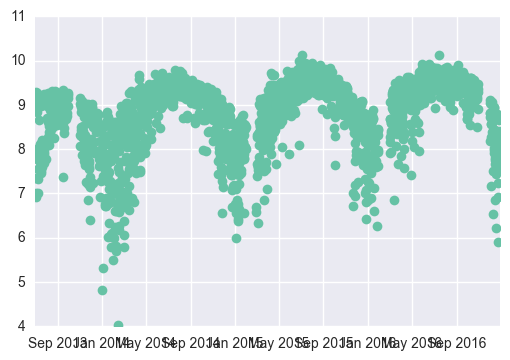

In [113]:
#Count over time
plt.plot_date(model_df.Date, model_df.log_total, xdate = True)

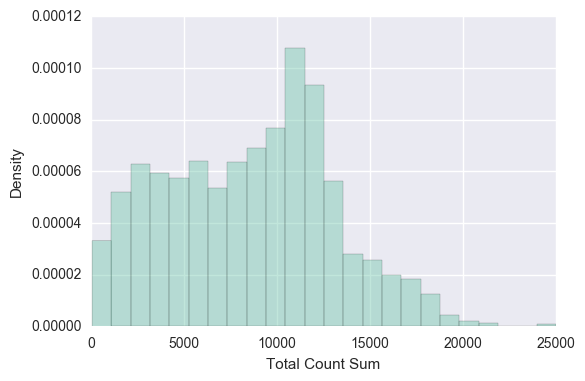

In [114]:
#Dependent distributions
ax = sns.distplot(model_df['Total_Count sum'], kde = False, rug = False, norm_hist = True)
plt.xlabel('Total Count Sum')
ax.set_ylabel('Density')
plt.show()

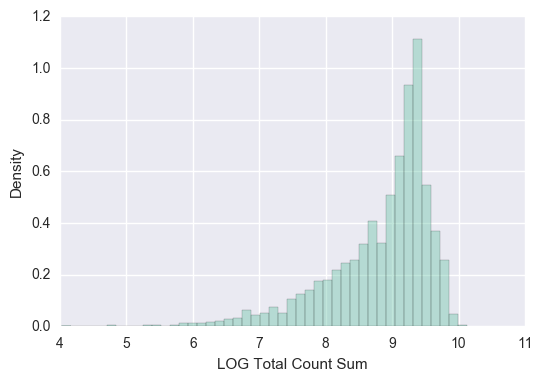

In [115]:
#Log distributions
ax = sns.distplot(y, kde = False, rug = False, norm_hist = True)
plt.xlabel('LOG Total Count Sum')
ax.set_ylabel('Density')
plt.show()

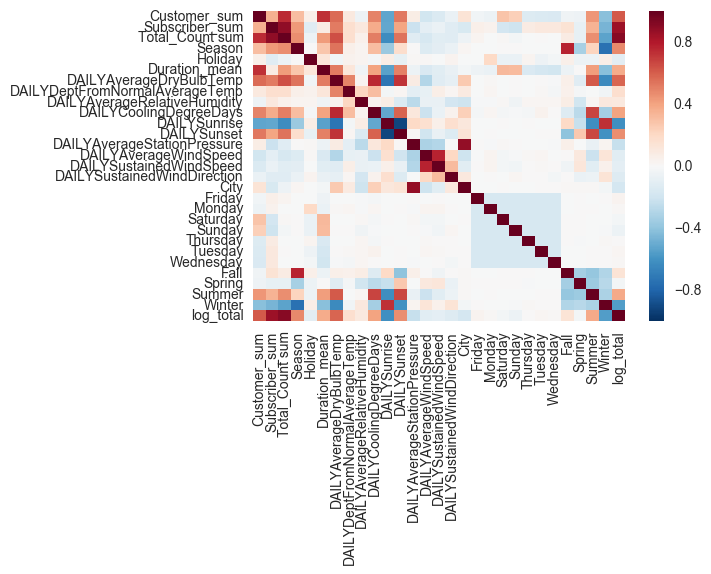

In [116]:
#Correlation Heatmap
corr = model_df.corr()
sns.heatmap(corr)

In [117]:
#Correlation Values List
s = corr.unstack()
so = s.order(kind = 'quicksort')
pp = pprint.PrettyPrinter()
pp.pprint(so)

#Dropped (Based on correlation and heatmap): 
# DAILYMaximumDryBulbTemp DAILYMinimumDryBulbTemp (Kept average)
# DAILYAverageSeaLevelPressure (Lower corr to dependent since redundant)
# DAILYPeakWindSpeed PeakWindDirection (Kept Average)
# DAILYAverageDewPointTemp DAILYAverageWetBulbTemp (Lower corr to dependent since redundant)

DAILYSunrise                    DAILYSunset                      -0.920910
DAILYSunset                     DAILYSunrise                     -0.920910
Season                          Winter                           -0.749454
Winter                          Season                           -0.749454
DAILYAverageDryBulbTemp         DAILYSunrise                     -0.730612
DAILYSunrise                    DAILYAverageDryBulbTemp          -0.730612
DAILYAverageDryBulbTemp         Winter                           -0.638198
Winter                          DAILYAverageDryBulbTemp          -0.638198
Total_Count sum                 DAILYSunrise                     -0.631289
DAILYSunrise                    Total_Count sum                  -0.631289
Summer                          DAILYSunrise                     -0.620321
DAILYSunrise                    Summer                           -0.620321
                                log_total                        -0.612576
log_total                

# Categorical Boxplots

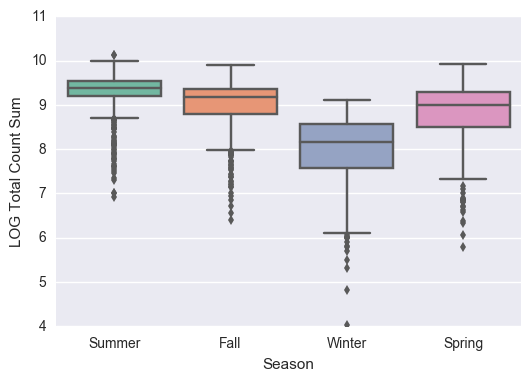

In [118]:
seasons_df = model_df[['log_total', 'Season']]
#Log Weekday Boxplots
ax = sns.boxplot(y, groupby = bike_df.Season_Name)
ax.set_ylabel('LOG Total Count Sum')
plt.xlabel('Season')
plt.show()

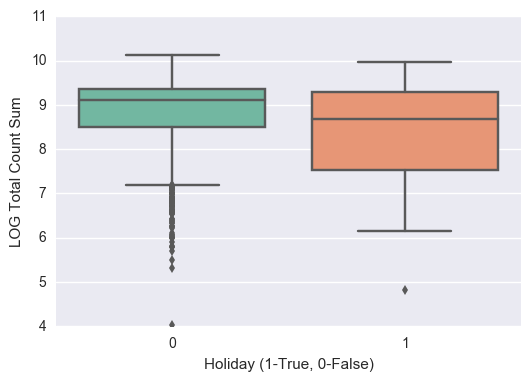

In [119]:
#Log Holiday Boxplots
ax = sns.boxplot(y, groupby = model_df.Holiday)
ax.set_ylabel('LOG Total Count Sum')
plt.xlabel('Holiday (1-True, 0-False)')
plt.show()

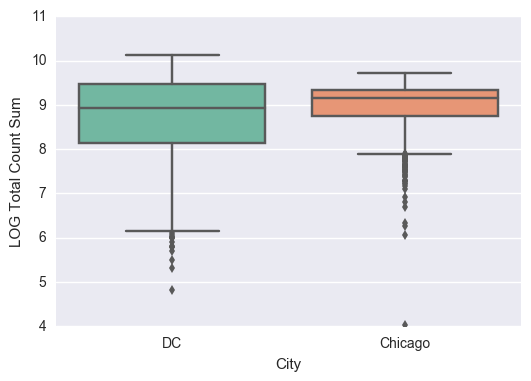

In [120]:
#Log City Boxplots
ax = sns.boxplot(y, groupby = bike_df.City)
ax.set_ylabel('LOG Total Count Sum')
plt.show()

# Training and Test Sets

In [121]:
#Create training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7777)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1765, 19)
(1765,)
(442, 19)
(442,)


# Log-Linear Regression Model

In [122]:
#Linear Regression Model
lm = smf.OLS(y_train.astype(float), X_train.astype(float))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_total   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     112.1
Date:                Sat, 03 Jun 2017   Prob (F-statistic):          3.90e-275
Time:                        15:49:41   Log-Likelihood:                -1364.8
No. Observations:                1765   AIC:                             2768.
Df Residuals:                    1746   BIC:                             2872.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Season                             0.0327      0.022      1.457      0.145        -0.011     0.077
Holiday                           -0.5303      0.084     -6.339      0.000        -0.694    -0.366
Duration_mean                      0.0157      0.004      3.532      0.000         0.007     0.024
DAILYAverageDryBulbTemp            0.0190      0.002      7.635      0.000         0.014     0.024
DAILYDeptFromNormalAverageTemp    -0.0056      0.003     -1.807      0.071        -0.012     0.000
DAILYAverageRelativeHumidity       0.0023      0.001      2.260      0.024         0.000     0.004
DAILYSunrise                      -0.0050      0.001     -8.745      0.000        -0.006    -0.004
DAILYSunset                       -0.0036      0.001     -6.594      0.000        -0.005    -0.003
DAILYSnowDepth                     0.0181      0.009      1.977      0.048         0.000     0.036
DAILYAverageWindSpeed              0.0229      0.006      3.760      0.000         0.011     0.035
DAILYSustainedWindSpeed           -0.0148      0.003     -4.500      0.000        -0.021    -0.008
City                              -0.1936      0.042     -4.613      0.000        -0.276    -0.111
Friday                            16.7171      1.252     13.351      0.000        14.261    19.173
Monday                            16.7086      1.252     13.344      0.000        14.253    19.164
Saturday                          16.5429      1.253     13.203      0.000        14.085    19.000
Sunday                            16.4839      1.252     13.161      0.000        14.027    18.940
Thursday                          16.7023      1.253     13.327      0.000        14.244    19.160
Tuesday                           16.7118      1.253     13.341      0.000        14.255    19.169
Wednesday                         16.7091      1.252     13.351      0.000        14.254    19.164
==============================================================================
Omnibus:                      517.005   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2076.749
Skew:                          -1.370   Prob(JB):                         0.00
Kurtosis:                       7.554   Cond. No.                     4.98e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Residual Analysis

In [123]:
#Calculate residuals
predicted = results.fittedvalues
res = y_train - predicted

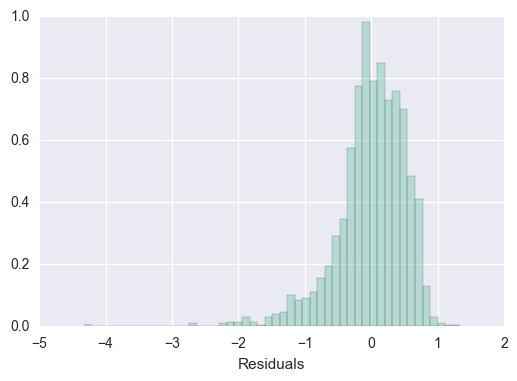

In [124]:
#Residual distribution
ax = sns.distplot(res, kde = False, rug = False, norm_hist = True)
plt.xlabel('Residuals')
plt.show()

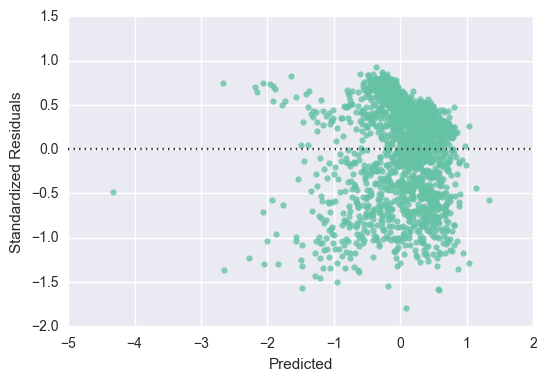

In [125]:
#Normal Residuals Plot
ax = sns.residplot(res, predicted)
plt.xlabel('Predicted')
ax.set_ylabel('Standardized Residuals')
plt.show()

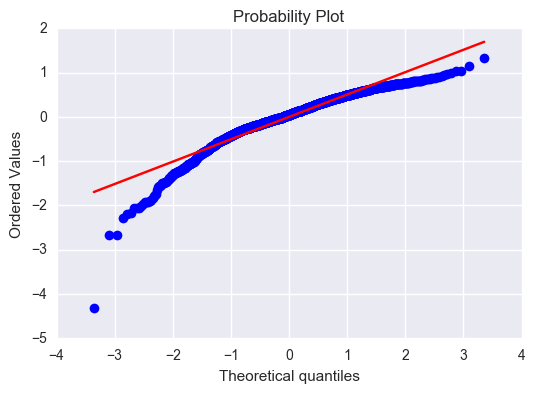

In [126]:
#Probability Plot
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(res, dist="norm", plot=pylab)
pylab.show()

# Predictions

TypeError: 'str' object is not callable

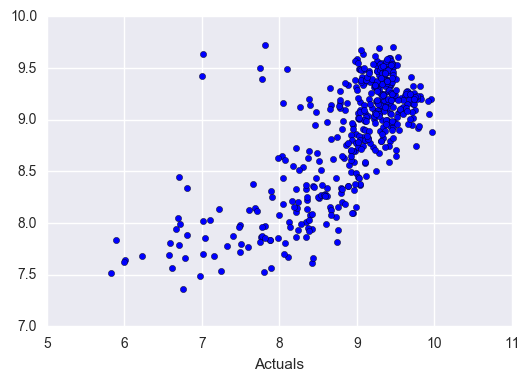

In [127]:
#Prediction on test set, plot predicted vs. actuals
preds = results.predict(X_test.astype(float))
plt.scatter(y_test, preds)
plt.xlabel('Actuals')
plt.ylabel('Predicted')